In [100]:
import copy
import numpy as np
import matplotlib.pyplot as plotter
import cv2
from ripser import ripser
from persim import PersistenceImager

In [92]:
def find_connected_components(binary_image):
    # connectivity 8 means that diagonally connected pixels are also considered connected
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
    centroids = centroids[1:]
    return centroids

def data_preparation(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    point_cloud = find_connected_components(binary_image)
    return image, binary_image, point_cloud

In [93]:
def plot_data_preparation(image, point_cloud, binary_image):
    plotter.figure(figsize=(18, 6))

    plotter.subplot(1, 3, 1)
    plotter.imshow(image)
    plotter.title('Original Image')
    plotter.axis('off')

    plotter.subplot(1, 3, 2)
    plotter.imshow(binary_image, cmap='gray')
    plotter.title('Binary Image')
    plotter.axis('off')

    plotter.subplot(1, 3, 3)
    plotter.scatter(point_cloud[:, 0], point_cloud[:, 1], s=1)
    plotter.title('Point Cloud from Centroids')

    # Use inverted y-axis to match image coordinates
    plotter.gca().invert_yaxis()
    plotter.axis('equal')

In [105]:
def create_persistence_image(H1_copy):
    H1_copy = H1_copy[np.isfinite(H1_copy[:, 1])]
    print(f"Number of finite H1 features: {len(H1_copy)}")

    p_image = PersistenceImager(pixel_size=1.0).fit_transform([H1_copy])[0]

    plotter.figure(figsize=(10, 6))
    plotter.imshow(p_image, cmap='viridis', origin='lower')
    plotter.title("Persistence Image (H1)")
    plotter.colorbar()

In [ ]:
image, binary_image, point_cloud = data_preparation("LSS.png")

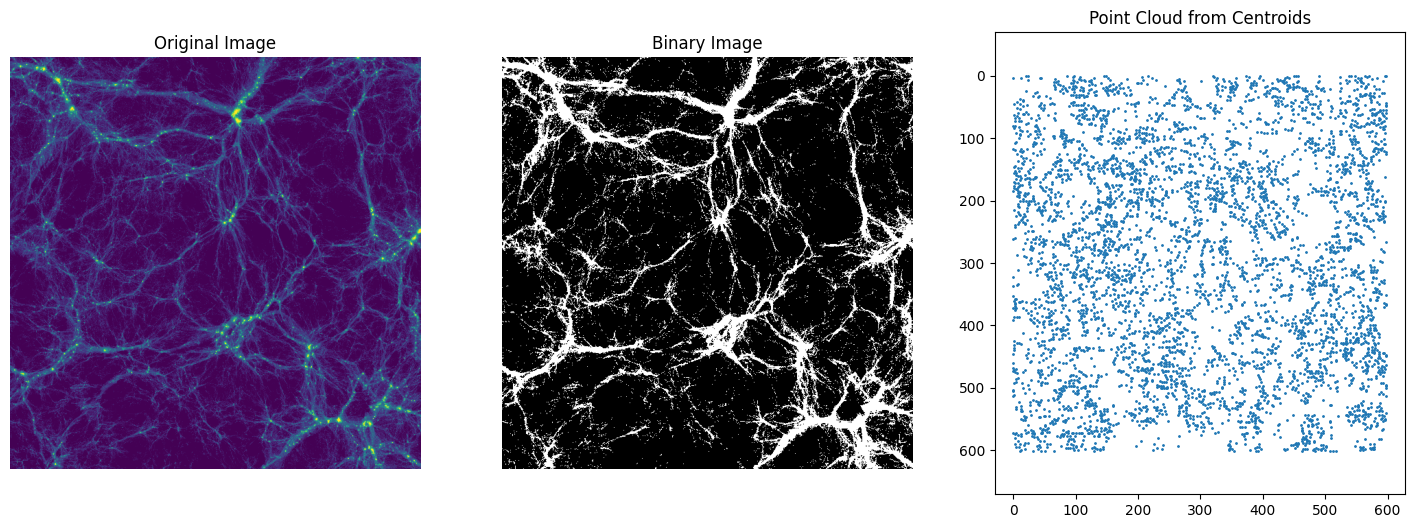

In [95]:
plot_data_preparation(image, point_cloud, binary_image)

In [ ]:
diagrams = ripser(point_cloud, maxdim=1)['dgms']

In [ ]:
print(f"Number of points in point cloud: {len(point_cloud)}")
print(f"{len(diagrams[0])} H0 features and {len(diagrams[1])} H1 features")

In [89]:
H0 = diagrams[0]
H1 = diagrams[1]

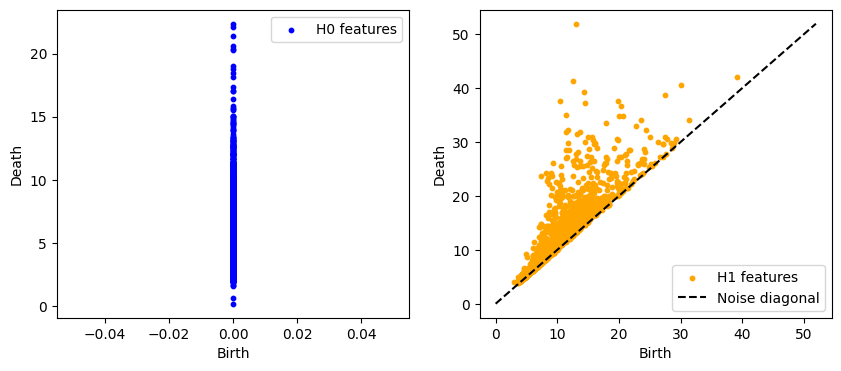

In [96]:
plotter.figure(figsize=(10, 4))

plotter.subplot(1, 2, 1)
plotter.scatter(H0[:, 0], H0[:, 1], c='blue', s=10, label='H0 features')
plotter.xlabel("Birth")
plotter.ylabel("Death")
plotter.legend()

plotter.subplot(1, 2, 2)
plotter.scatter(H1[:, 0], H1[:, 1], c='orange', s=10, label='H1 features')
plotter.xlabel("Birth")
plotter.ylabel("Death")
plotter.plot([0, np.max(H1)], [0, np.max(H1)], 'k--', label='Noise diagonal')
plotter.legend()

The H0 features are connecte components, so all points start as connected components at scale \epsilon = 0 but they soon die (merge into bigger structures) as we increase the scale. The longest persisting H0 features would be non-trivial galaxy or halos that remain isolated for larger scales.

The H1 features represent some connected loops or filaments. The diagonal is features that only appear trivially at some scale and disappear immediately. This is probably just noise? The more off diagonal, the more non-trivial a feature. Since each point represents a topoligical features, we can plot the longest lived features on the binary image to see what they correspond to

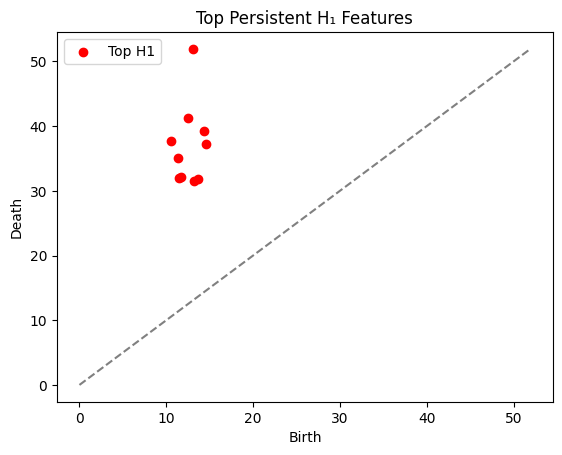

In [97]:
H1_persistence = H1[:,1] - H1[:,0]
max_indices = np.argsort(H1_persistence)[-10:] # choose 10
max_H1_persistence = H1[max_indices]

plotter.scatter(max_H1_persistence[:, 0], max_H1_persistence[:, 1], c='red', label='Top H1')
plotter.plot([0, np.max(H1)], [0, np.max(H1)], '--', color='gray')
plotter.xlabel("Birth")
plotter.ylabel("Death")
plotter.title("Top Persistent H₁ Features")
plotter.legend()
plotter.show()

Number of finite H1 features: 1207


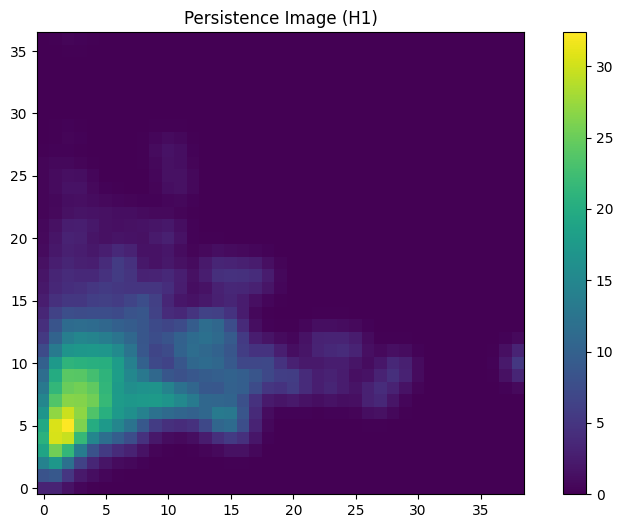

In [106]:
pi = create_persistence_image(copy.deepcopy(H1))

The plot shows persistence (y-axis) vs birth scale (x-axis) so the brightest region (brith at 2-3) and persistence of (5-6) probably corresponds to true, non-trivial filaments or void edges in the matter distribution. This seems plausible given the image itself shows obvious connected regions. The patches at higher birth scale (> 20) seem like a result of the smoothing and are probably noise because of how short lived hey are. The bottom left region is the small birth scale, small persistence region, and likely to be noise.